# Transformer Architecture

In this notebook we will implement the Transformer architecture, which has had a key impact on the development of NLP and other areas of machine learning since its introduction in 2017.

## Theory

Let's recall what the **attention mechanism** is and what it consists of.

Literature says: *The attention mechanism describes a weighted average of sequence elements with the weights dynamically computed based on an input query and elements' keys.*

To clarify, this means that rather than simply averaging the features of multiple elements equally, we aim to assign different weights to each element depending on its relevance or value. And we want to dynamically determine which inputs deserve more "attention" than others.

An attention mechanism consists of three key components:

*   **Query:** The query is a feature vector that describes what we are looking for in the sequence, i.e. what would we maybe want to pay attention to.
*   **Keys:** For each input element, we have a key which is again a feature vector. This feature vector roughly describes what the element is “offering”, or when it might be important. The keys should be designed such that we can identify the elements we want to pay attention to based on the query.
*   **Values:** For each input element, we also have a value vector. This feature vector is the one we want to average over.

The weights of the average are calculated by a softmax over Query-Key score (which is most often just their dot product). Therefore, we assign higher weights to the value vectors whose corresponding keys are most similar to the query.

Visually, it can be shown as follows:

![](https://raw.githubusercontent.com/lwtztea/ml_pic/f8af000/week_3/attention.png)

**Todo:** add smth about self-attention

## Implementation

Let's implement an [original paper](!https://arxiv.org/pdf/1706.03762)!

In [1]:
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn

<img src = https://raw.githubusercontent.com/lwtztea/ml_pic/f8af000/week_3/transformer.png width = "500" >

### 1. Positional Encoding

$PE_{(pos, i)}$ represents the position encoding at **position** $pos$ in the sequence and **hidden dimensionality** $i$:

\begin{split}PE_{(pos,i)} = \begin{cases}
\sin \left( \frac{pos}{10000^{i/d_{model}}} \right) & \text{if}\hspace{3mm} i \text{ mod } 2 = 0 \\
\cos \left( \frac{pos}{10000^{(i-1)/d_{model}}} \right) & \text{otherwize}
\end{cases}\end{split}

In [2]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() *
            (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        return x + self.pe[:, :x.size(1)]  # token embedding + positional encoding

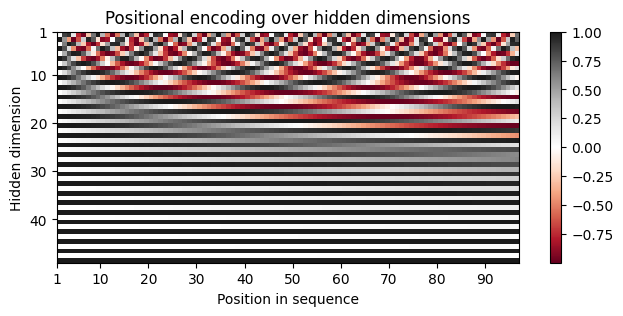

In [3]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1, pe.shape[1] + 1, pe.shape[0] + 1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1] + [i * 10 for i in range(1, 1 + pe.shape[1] // 10)])
ax.set_yticks([1] + [i * 10 for i in range(1, 1 + pe.shape[0] // 10)])
plt.show()

### 2. Scaled Dot-Product Attention

The input consists of queries and keys of dimension $d_k$ , and values of dimension $d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the
values.

<img src = https://raw.githubusercontent.com/lwtztea/ml_pic/f8af000/week_3/scaled%20dot%20product%20attention.png width = "500" >

$$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$

In [4]:
class ScaledDotProductAttention(nn.Module):

    def __init__(self, dropout=0.1):
        super(ScaledDotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        d_k = q.size(-1)
        # (batch, head, seq_len, head_dim) --> (batch, h, seq_len, seq_len)
        attn_logits = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

        if mask is not None:
            attn_logits = attn_logits.masked_fill(mask == 0, -1e9)

        attention = torch.softmax(attn_logits, dim=-1)
        attention = self.dropout(attention)

        values = torch.matmul(attention, v)
        return values, attention

In [5]:
seq_len, d_k = 3, 2

q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)

scaled_dot_product = ScaledDotProductAttention()
values, attention = scaled_dot_product.forward(q, k, v)

print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[-0.4130, -0.9796],
        [-1.2811,  1.4837],
        [ 1.6496,  1.5318]])
K
 tensor([[-0.4710,  1.0884],
        [ 0.0147,  0.0921],
        [-1.1329, -0.1329]])
V
 tensor([[-0.1128,  0.3823],
        [-1.2206,  0.5437],
        [ 0.0885, -1.3228]])
Values
 tensor([[-0.3948, -0.4832],
        [-0.2209, -0.1050],
        [-0.5374,  0.3517]])
Attention
 tensor([[0.1999, 0.3459, 0.5653],
        [0.6415, 0.1453, 0.3244],
        [0.6453, 0.3864, 0.0794]])


### 3. Multi-Head Attention

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions.

<img src = https://raw.githubusercontent.com/lwtztea/ml_pic/f8af000/week_3/multi%20head%20attention.png width = "500" >

\begin{split}
\text{MultiHead}(Q, K, V) &= \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O \\
\text{where } \text{head}_i &= \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
\end{split}

where the projections are trainable matrices
$W_i^Q \in \mathbb{R}^{d_{model} \times d_k}$,
$W_i^K \in \mathbb{R}^{d_{model} \times d_k}$,
$W_i^V \in \mathbb{R}^{d_{model} \times d_v}$ and
$W_i^O \in \mathbb{R}^{hd_v \times d_{model}}$.

In [6]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert (d_model % num_heads == 0), "Embedding dimension must be 0 modulo number of heads."

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.attention = ScaledDotProductAttention(dropout)

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)

    def _split(self, x):
        batch_size, seq_length, _ = x.size()
        x = x.view(batch_size, seq_length, self.num_heads, self.head_dim)  # (batch, seq_len, head, head_dim)
        x = x.transpose(1, 2)  # (batch, head, seq_len, head_dim)

        return x

    def _concat(self, x):
        batch_size, _, seq_length, _ = x.size()
        x = x.transpose(1, 2).contiguous()  # (batch, seq_len, head, head_dim)
        x = x.view(batch_size, seq_length, self.d_model)  # (batch, seq_len, d_model)

        return x

    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by number of heads
        q, k, v = self._split(q), self._split(k), self._split(v)

        # 3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v, mask=mask)

        # 4. concat and pass to linear layer
        out = self._concat(out)
        out = self.w_concat(out)

        return out, attention

### 4. Layer Normalization

The Layer Normalization also plays an important role in the Transformer architecture as it enables faster training and provides small regularization. Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence. We are not using Batch Normalization because it depends on the batch size which is often small with Transformers (they require a lot of GPU memory), and BatchNorm has shown to perform particularly bad in language as the features of words tend to have a much higher variance (there are many, very rare words which need to be considered for a good distribution estimate).

<img src = https://raw.githubusercontent.com/lwtztea/ml_pic/f8af000/week_3/layer%20normalization.png width = "500" >

$$
\hat{x} = \frac{x - \text{E}(x)}{\sqrt{\text{Var}(x) + \epsilon}} \cdot \gamma + \beta
$$
where $\epsilon$ is a small constant added for numerical stability,
$\gamma$ and $\beta$ are learnable parameters that scale and shift the normalized values.

The mean and standard-deviation are calculated over the last D dimensions.

In [7]:
batch_size, seq_len, d_model = 1, 3, 2

mini_batch = torch.randn(batch_size, seq_len, d_model)
layer_norm = nn.LayerNorm(d_model)  # normalize over embedding dimention
layer_norm_2 = nn.LayerNorm((seq_len, d_model))  # normalize over sequence and embedding dimentions

print("Batch values\n", mini_batch)
print()
print("Normalized embeddings\n", layer_norm(mini_batch))
print()
print("Normalized embeddings and sequences\n", layer_norm_2(mini_batch))

Batch values
 tensor([[[ 1.5594,  0.8827],
         [-0.7877,  1.5221],
         [-1.7949,  0.7269]]])

Normalized embeddings
 tensor([[[ 1.0000, -1.0000],
         [-1.0000,  1.0000],
         [-1.0000,  1.0000]]], grad_fn=<NativeLayerNormBackward0>)

Normalized embeddings and sequences
 tensor([[[ 0.9778,  0.4301],
         [-0.9220,  0.9476],
         [-1.7374,  0.3039]]], grad_fn=<NativeLayerNormBackward0>)


### 5. Feed Forward Network

Additionally to the Multi-Head Attention, a small fully connected feed-forward network is added to the model, which is applied to each position separately and identically. Specifically, the model uses a LinearReLULinear MLP (Multilayer Perceptron). The full transformation including the residual connection can be expressed as:

\begin{split}
\text{FFN}(x) &= \max (0, xW_1 + b)W_2 + b_2 \\
x &= \text{LayerNorm}(x + \text{FFN}(x)) \\
\end{split}

This MLP adds extra complexity to the model and allows transformations on each sequence element separately. You can imagine as this allows the model to “post-process” the new information added by the previous Multi-Head Attention, and prepare it for the next attention block.

In [8]:
class FeedForward(nn.Module):

    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(torch.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

### 6. Encoder Block

In [9]:
class EncoderBlock(nn.Module):

    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderBlock, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, _ = self.self_attn(x, x, x, mask)
        x = x + self.dropout_1(attn_output)
        x = self.norm_1(x)

        ff_output = self.feed_forward(x)
        x = x + self.dropout_2(ff_output)
        x = self.norm_2(x)

        return x

### 7. Decoder Block

In [10]:
class DecoderBlock(nn.Module):

    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderBlock, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)
        self.norm_3 = nn.LayerNorm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)

    def forward(self, x, memory, src_mask=None, tgt_mask=None):
        attn_output, _ = self.self_attn(x, x, x, tgt_mask)
        x = x + self.dropout_1(attn_output)
        x = self.norm_1(x)

        attn_output, _ = self.cross_attn(x, memory, memory, src_mask)
        x = x + self.dropout_2(attn_output)
        x = self.norm_2(x)

        ff_output = self.feed_forward(x)
        x = x + self.dropout_3(ff_output)
        x = self.norm_3(x)

        return x

### 8. Full Transformer Model

In [11]:
class Transformer(nn.Module):

    def __init__(
        self,
        src_vocab_size,
        tgt_vocab_size,
        d_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        d_ff,
        dropout=0.1,
        max_len=5000,
    ):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList([
            EncoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_encoder_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_decoder_layers)
        ])
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def encode(self, src, src_mask=None):
        x = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        for layer in self.encoder_layers:
            x = layer(x, src_mask)
        return x

    def decode(self, tgt, memory, src_mask=None, tgt_mask=None):
        x = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        for layer in self.decoder_layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return x

    def generate_square_subsequent_mask(self, seq_size):
        mask = (torch.triu(torch.ones(seq_size, seq_size)) == 1).transpose(0, 1)
        mask = (mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0)))
        return mask

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        if tgt_mask is None:
            tgt_mask = self.generate_square_subsequent_mask(tgt.size(1))

        encoder_output = self.encode(src, src_mask)
        decoder_output = self.decode(tgt, encoder_output, src_mask, tgt_mask)
        output = self.fc_out(decoder_output)
        return output

In [12]:
torch.triu(torch.ones(4, 4)).transpose(0, 1)

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

## Usage example

In [13]:
# Hyperparams
src_vocab_size = 8000
tgt_vocab_size = 9000
d_model = 512
num_heads = 8
num_encoder_layers = 6
num_decoder_layers = 6
d_ff = 2048
dropout = 0.1

# Initialization
model = Transformer(
    src_vocab_size,
    tgt_vocab_size,
    d_model,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    d_ff,
    dropout,
)

# Inputs
src = torch.randint(0, src_vocab_size, (32, 10))  # Batch size = 32, Seq length = 10
tgt = torch.randint(0, tgt_vocab_size, (32, 10))

# Prediction
output = model(src, tgt)
print(output.shape)  # (batch_size, seq_len, tgt_vocab_size)

torch.Size([32, 10, 9000])


### Now you can train it :)

In [14]:
# YOUR CODE HERE